# Echo State Stochastic Volatility Heston Dynamical Model



In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from numba import jit
import math
import os
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [162]:
class Reservoir(object):
    """
    Build a reservoir and evaluate internal states
    
    Parameters:
        n_internal_units = processing units in the reservoir
        spectral_radius = largest eigenvalue of the reservoir matrix of connection weights
        leak = amount of leakage in the reservoir state update (optional)
        connectivity = percentage of nonzero connection weights (unused in circle reservoir)
        input_scaling = scaling of the input connection weights
        noise_level = deviation of the Gaussian noise injected in the state update
        circle = generate determinisitc reservoir with circle topology
    """
    
    def __init__(self, n_internal_units=100, spectral_radius=0.99, leak=None,
                 connectivity=0.3, input_scaling=0.2, noise_level=0.01, circle=False):
        
        # Initialize attributes
        self._n_internal_units = n_internal_units
        self._input_scaling = input_scaling
        self._noise_level = noise_level
        self._leak = leak

        # Input weights depend on input size: they are set when data is provided
        self._input_weights = None

        # Generate internal weights
        if circle:
            self._internal_weights = self._initialize_internal_weights_Circ(
                    n_internal_units,
                    spectral_radius)
        else:
            self._internal_weights = self._initialize_internal_weights(
                n_internal_units,
                connectivity,
                spectral_radius)


    def _initialize_internal_weights_Circ(self, n_internal_units, spectral_radius):
        
        internal_weights = np.zeros((n_internal_units, n_internal_units))
        internal_weights[0,-1] = spectral_radius
        for i in range(n_internal_units-1):
            internal_weights[i+1,i] = spectral_radius
                
        return internal_weights
    
    
    def _initialize_internal_weights(self, n_internal_units,
                                     connectivity, spectral_radius):

        # Generate sparse, uniformly distributed weights.
        internal_weights = sparse.rand(n_internal_units,
                                       n_internal_units,
                                       density=connectivity).todense()

        # Ensure that the nonzero values are uniformly distributed in [-0.5, 0.5]
        internal_weights[np.where(internal_weights > 0)] -= 0.5
        
        # Adjust the spectral radius.
        E, _ = np.linalg.eig(internal_weights)
        e_max = np.max(np.abs(E))
        internal_weights /= np.abs(e_max)/spectral_radius       

        return internal_weights


    def _compute_state_matrix(self, X, n_drop=0):
        N, T, _ = X.shape
        previous_state = np.zeros((N, self._n_internal_units), dtype=float)

        # Storage
        state_matrix = np.empty((N, T - n_drop, self._n_internal_units), dtype=float)
        for t in range(T):
            current_input = X[:, t, :]

            # Calculate state
            state_before_tanh = self._internal_weights.dot(previous_state.T) + self._input_weights.dot(current_input.T)

            # Add noise
            state_before_tanh += np.random.rand(self._n_internal_units, N)*self._noise_level

            # Apply nonlinearity and leakage (optional)
            if self._leak is None:
                previous_state = np.tanh(state_before_tanh).T
            else:
                previous_state = (1.0 - self._leak)*previous_state + np.tanh(state_before_tanh).T

            # Store everything after the dropout period
            if (t > n_drop - 1):
                state_matrix[:, t - n_drop, :] = previous_state

        return state_matrix


    def get_states(self, X, n_drop=0, bidir=True):
        N, T, V = X.shape
        if self._input_weights is None:
            self._input_weights = (2.0*np.random.binomial(1, 0.5 , [self._n_internal_units, V]) - 1.0)*self._input_scaling

        # compute sequence of reservoir states
        states = self._compute_state_matrix(X, n_drop)
    
        # reservoir states on time reversed input
        if bidir is True:
            X_r = X[:, ::-1, :]
            states_r = self._compute_state_matrix(X_r, n_drop)
            states = np.concatenate((states, states_r), axis=2)

        return states
    
    def getReservoirEmbedding(self, X,pca, ridge_embedding,  n_drop=5, bidir=True, test = False):

        res_states = self.get_states(X, n_drop=5, bidir=True)


        N_samples = res_states.shape[0]
        res_states = res_states.reshape(-1, res_states.shape[2])                   
        # ..transform..
        if test:
            red_states = pca.transform(res_states)
        else:
            red_states = pca.fit_transform(res_states)          
        # ..and put back in tensor form
        red_states = red_states.reshape(N_samples,-1,red_states.shape[1])  

        coeff_tr = []
        biases_tr = []   

        for i in range(X.shape[0]):
            ridge_embedding.fit(red_states[i, 0:-1, :], red_states[i, 1:, :])
            coeff_tr.append(ridge_embedding.coef_.ravel())
            biases_tr.append(ridge_embedding.intercept_.ravel())
        print(np.array(coeff_tr).shape,np.array(biases_tr).shape)
        input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        return input_repr


-----------------------------------------------Making Transition and input matrix------------------------------------------------

Shape of W:  (5000, 5000)
Shape of W_in: (5000, 5)

-----------------------------------------------Making input and inner states------------------------------------------------------

Inner States: # of samples x # of dimension: (1001, 5000)
Input States: # of samples x # of dimension: (1000, 5)

------------------------------------------------Concatena data and Y sequence data------------------------------------------------

Inner + Input States: # of samples x # of dimension: (1000, 5005)
Targeted fitting sequence: # of samples x # of dimension: (1000, 1)

--------------------------------------------------Splitting Data to 3-------------------------------------------------------------

useless_X: # of samples x # of dimension: (200, 5005)
useless_Y: # of samples x # of dimension: (200, 1)
regress_X: # of samples x # of dimension: (600, 5005)
regress_Y: #

C:\Users\ziyangding\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


best_alpha: 0.01
best_mse: 135740.12066922514
regress coefficient length: 5005
first 5 coefficient of model: [ 30.12336036   8.07477678  67.50456814  -7.83432233 -80.35697936]
Predicted length equal to target length: True

-----------------------------------------------Producing Graphic Visualization----------------------------------------------------

mse 139979.59094735503


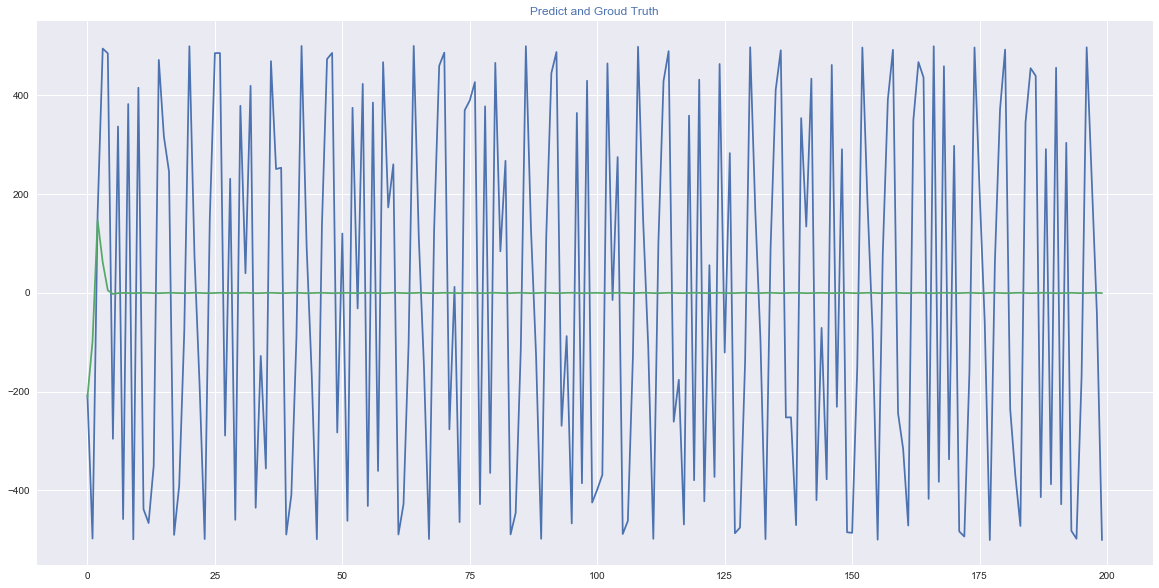

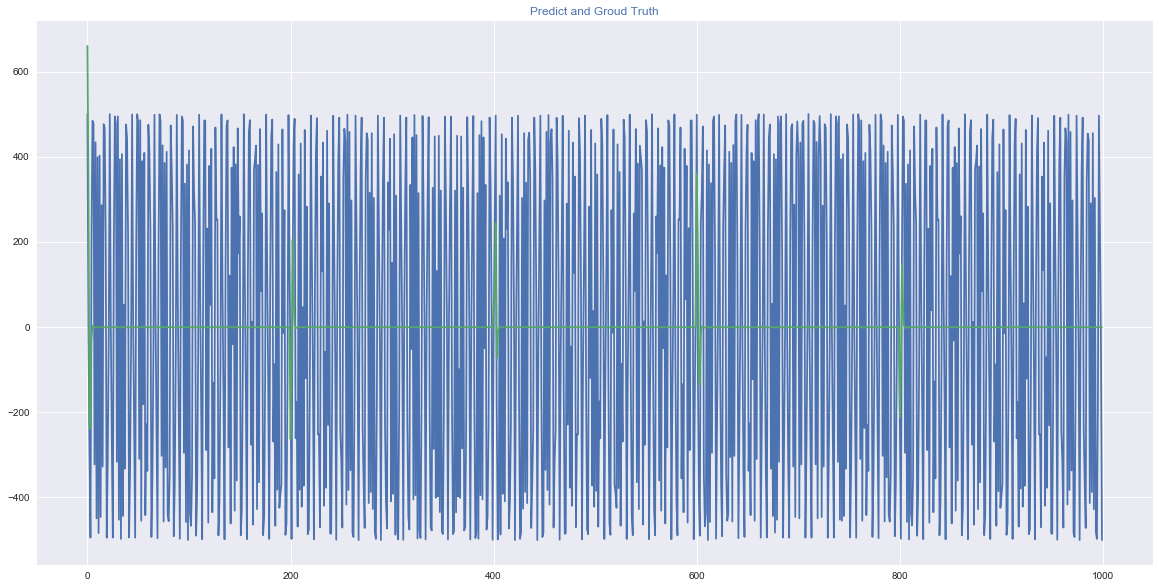

In [139]:
x_dim = 1000
u_num = 1000
u_dim = 5
u_mag = 4
cutout = 200

print()
print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
print()

# Making inner transition sparse matrix W
nans = np.random.randint(0,20, size=(x_dim, x_dim))
W = np.random.uniform(-100, 100, x_dim*x_dim).reshape([x_dim, x_dim])
W = np.where(nans, np.nan, W)
W = np.nan_to_num(W)
W = W / (np.linalg.svd(W)[1].tolist()[0]*1.2)


# Making input matrix W_in
W_in = np.random.uniform(-5, 5, x_dim*u_dim).reshape([x_dim, u_dim])
W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

print("Shape of W: ", str(W.shape))
print("Shape of W_in:", str(W_in.shape))

print()
print("-----------------------------------------------Making input and inner states------------------------------------------------------")
print()

# Making input states
u = []
for i in range(u_dim):
    ui = []
    for j in range(u_num):
        ui.append(math.cos(i)*math.sin(j+i))
    ui = np.array(ui)
    u.append(ui)
u = np.array(u).reshape(u_num, u_dim)

# Making Inner States
x_list = [np.zeros([x_dim])]
for i in range(u_num):
    x_next = np.tanh( np.matmul(W_in, u[i]) + np.matmul(W, x_list[-1]))
    x_list.append(x_next)

states = np.array(x_list).reshape(u_num+1, x_dim)


print("Inner States: # of samples x # of dimension:", str(states.shape))
print("Input States: # of samples x # of dimension:", str(u.shape))

print()
print("------------------------------------------------Concatena data and Y sequence data------------------------------------------------")
print()

# Making Concatenated data
X = np.concatenate([states[:-1,:], u], axis=1)

# Making Target sequence
Y = []
for j in range(u_num):
    Y.append((-1)**j*500*math.cos(math.tan(j))+math.cos(100*j))
Y = np.array(Y).reshape([u_num, 1])



print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

print()
print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
print()

# Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
useless_X = X[:cutout, :]
useless_Y = Y[:cutout, :]

regress_X = X[cutout:-cutout, :]
regress_Y = Y[cutout:-cutout, :]

predict_X = X[-cutout:, :]
predict_Y = Y[-cutout:, :]


print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

print()
print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
print()

alpha = 0
mse = {}
while alpha <= 1:
    
    # Conducting linear regression
    reg = Ridge(alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    alpha += 0.01
    
    loss = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    mse[alpha] = loss
    
    
    
#mpl.style.use("seaborn")
#fig, ax = plt.subplots(figsize=(20, 10))
#ax.set_title('CV for regression coefficient'.format("seaborn"), color='C0')   
#ax.plot(list(mse.keys()), list(mse.values()))

best_mse = min(list(mse.values()))
best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


# using best  regression again
reg = Ridge(best_alpha).fit(regress_X, regress_Y)

# Making prediction
predhat_Y = reg.predict(predict_X)


print("best_alpha:", best_alpha)
print("best_mse:", best_mse)








print("regress coefficient length:", len(reg.coef_[0].tolist()))
print("first 5 coefficient of model:", reg.coef_[0, :5])
print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

print()
print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
print()


# Producing Graphic Visualization

# 后面100个，真实值与预测的
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])])


# 所有的，真实值与预测的
hat_Y = reg.predict(X)
mse = np.mean(np.multiply(   (hat_Y - Y), (hat_Y - Y)))

print("mse", mse)

mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(u_num)], [Y[j] for j in range(u_num)])
ax.plot([j for j in range(u_num)], [hat_Y[j] for j in range(u_num)])

(1000,)
(1000, 22)
[[ 0.          0.84147098  0.90929743 ...  0.14987721  0.
   0.        ]
 [ 0.91294525  0.83665564 -0.00885131 ...  0.96379539  0.24090467
  -0.36843574]
 [ 0.74511316 -0.15862267 -0.91652155 ...  0.63673801  0.21325224
  -0.81631784]
 ...
 [-0.71899052 -0.95955117 -0.31790489 ... -0.81258603  0.33526374
   0.0078817 ]
 [-0.91299332 -0.17399876  0.72496945 ... -0.84581026 -0.02312356
   0.77805005]
 [-0.02616187  0.81753962  0.90959895 ...  0.12226604 -0.34907358
   0.68647784]]


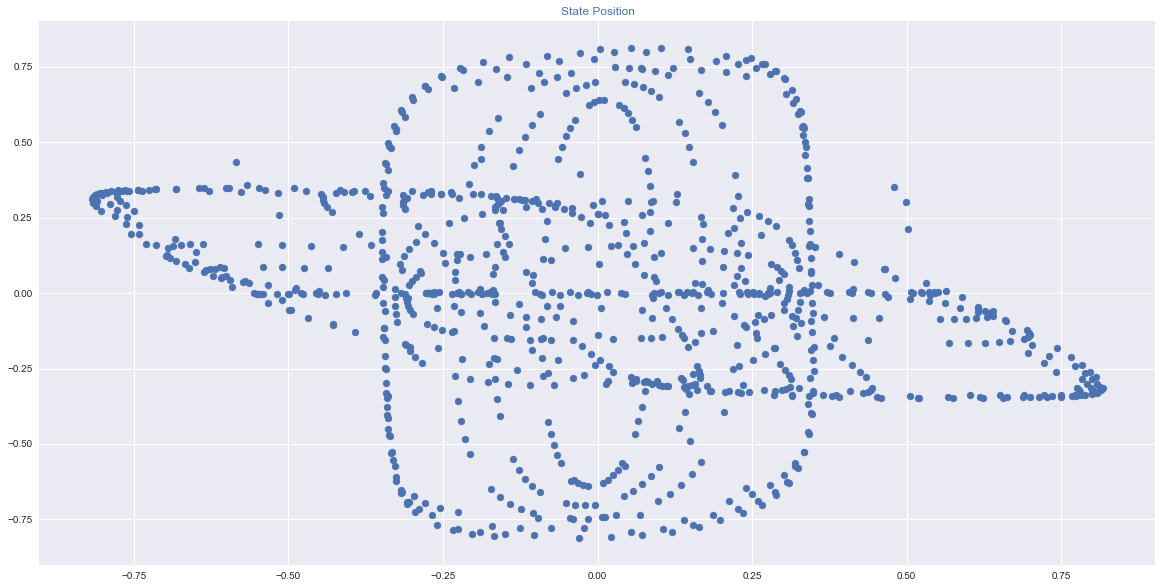

In [160]:
x_dim = 2
u_num = 1000
u_dim = 20
u_mag = 4
cutout = 100

nans = np.random.randint(0,10, size=(x_dim, x_dim))
W = np.random.uniform(-100, 100, x_dim*x_dim).reshape([x_dim, x_dim])
W = np.where(nans, np.nan, W)
W = np.nan_to_num(W)
W = W / (np.linalg.svd(W)[1].tolist()[0]*1.2)


u = []
for i in range(u_dim):
    ui = []
    for j in range(u_num):
        ui.append(math.cos(i)*math.sin(j+i))
    ui = np.array(ui)
    u.append(ui)
#u = np.random.uniform(-u_mag, u_mag, u_num*u_dim).reshape([u_num, u_dim])
u = np.array(u).reshape(u_num, u_dim)


W_in = np.random.uniform(-5, 5, x_dim*u_dim).reshape([x_dim, u_dim])

W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

x_list = [np.zeros([x_dim])]


for i in range(u_num):
    x_next = np.tanh( np.matmul(W_in, u[i]) + np.matmul(W, x_list[-1]))
    x_list.append(x_next)

states = np.array(x_list).reshape(u_num+1, x_dim)

    
    
# making fitting sequence
output = []
for j in range(u_num):
    output.append(10*math.cos(5)*math.sin(j+i))

    
    
    
    
output = np.array(output)
predictor = np.concatenate([u,  states[:-1,:]], axis =1)

print(output.shape)
print(predictor.shape)


print(predictor)

# making linear regression model
reg = LinearRegression().fit(predictor[cutout:u_num-cutout, :], output[cutout:u_num-cutout])


outhat = reg.predict(predictor[u_num-cutout:, :])
truth = output[u_num-cutout:]

"""
# 前面扔掉的100个，真实值与源数据
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Original data and output'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout)], [output[j] for j in range(outhat.shape[0])])
for i in range(2):
    ax.plot([j for j in range(cutout)], [predictor[i][j] for j in range(outhat.shape[0])])
plt.show()



# 全部的，真实值与源数据
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('input vs output before fitting'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout, u_num)], [output[j] for j in range(cutout, u_num)])
for i in range(20, 30):
    ax.plot([j for j in range(cutout, u_num)], [predictor[i][j] for j in range(cutout, u_num)])
plt.show() 
print((reg.coef_).tolist())


# 后面100个，真实值与预测的
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout)], [outhat[j] for j in range(outhat.shape[0])])
ax.plot([j for j in range(cutout)], [truth[j] for j in range(outhat.shape[0])])


# 所有的源数据
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('State Transition'.format("seaborn"), color='C0')   
   
for i in range(2):
    ax.plot([j for j in range(u_num)], [states[i][j] for j in range(u_num)])
        
plt.show() 




"""


mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('State Position'.format("seaborn"), color='C0')   
   
states = np.array(x_list).reshape(x_dim, u_num+1)
ax.scatter(states[0], states[1])
        
plt.show()


states = np.array(x_list).reshape(x_dim, u_num+1)


